We try to predict the next update (tick) arrival time.
We want to include shocks on the underlying and trade size in our model

The standard ACD Model looks like this :
$\psi(i) = \alpha_0 + \sum_{0<j=<p} \alpha_j x_{i-j} + \sum_{0=<j=<q} \beta_j \psi_{i-j}$

We can try to compare the performance with the following model :

Let's keep it for calls :
With K:Strike, F:Underlying

Moneyness : $ \omega  =  K/F$   

Shocks on the underlying : $ \lambda(F) = Time Weighted TradingVolumePastXTrades  $

Shocks on the Option : $ \lambda(O) =  Time Weighted TradingVolumePastXTrades $

dt : weighted time since volumes by volume

$\psi(i) = \alpha_0 + \sum_{1=<j=<p} \alpha_j log(x_{i-j}) + \sum_{0=<j=<q} \beta_j \psi_{i-j} + \sum_{0=<j=<s} \gamma_j \omega_{i-j} \lambda (O)_{i-j}   + \sum_{0=<j=<r} \delta_j \omega_{i-j} \lambda (U)_{i-j}$

As proposed by Bauwens and Giot (2000) we can take the logs to avoid constraints on the variables (keep stationarity)

In [188]:
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz

In [2]:
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [185]:

def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [3]:
data = json.load(open('feeddata_10.json'))

# Typical ACD Model on Futures:

In [4]:

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]    
    
    initialized = False
    first = True
    for idx, tick in enumerate(data):
    
        myBook = tick["book"]
           
        if myBook[5] == '1' and  tick['type']=='tick':   #let's forget about mini futures
            myContract = getBookContract(myBook[8:11],myBook[3])
    
            if myContract is CONTRACTTYPE.FUTURE:
                if initialized and not first :

                    #calculate alphas and betas parts
                    alphaSum = 0.0
                    betaSum = 0.0            
                    for idx2,alpha in enumerate(alphas): 
                        #print(xs)
                        alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                    for idx2,beta in enumerate(betas):
                        #print(psis)
                        if len(psis)>idx2:
                            betaSum = betaSum + beta*psis[idx2]

                    expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                    psis.append(expectedTime)
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)


                    errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                    check1.append(expectedTime)
                    check2.append(xs[p])

                elif first:
                    first = False
                else:
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)
                    if len(xs) == p:
                        initialized = True

                myPastTime = datetime.utcfromtimestamp(tick["created"]/1000000)

                #maintain right array size
                if len(xs)>p:
                    xs.pop(0)
                if len(psis)>q:
                    psis.pop(0)  

                if idx > 2000 :
                    break
    #return errs,check1,check2
    return np.average(errs)

In [5]:
# if 'xs' in globals() or 'psis' in globals():
#     sys.stderr.write('xs or/and psis variables already exist')
#else:


#parameters:
alpha0 = 0.0
alphas = [1,1,1,1,1,1]
betas = [1,1,1,1]

params0 = [alpha0] + alphas + betas
#errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))


# LSE

In [57]:
def constraint1(x):
    return -np.sum(x)+len(x)



cons = (
            {'type': 'ineq',
             'fun' : constraint1
            }
          ,
              {'type': 'ineq',
               'fun' : lambda x: x
              }
    
        )


In [7]:

optimize.minimize(residualTotalEACD,params0,args=([len(alphas), len(betas)]), method='COBYLA', constraints=cons, options={'maxiter':10000})

     fun: 1987.1733927191476
   maxcv: 1.0135269667632516e-19
 message: 'Optimization terminated successfully.'
    nfev: 8687
  status: 1
 success: True
       x: array([  1.34372277e+00,  -9.46518187e-20,  -7.80014531e-21,
        -9.89682264e-20,  -9.51935771e-20,  -1.00768977e-19,
         2.65618311e-01,   3.67002166e-01,   7.79119699e-22,
         2.93608638e-01,  -1.01352697e-19])

In [8]:
# we just check what we would get with random variables
paramsTest = [1,1,1]

for idx,param in enumerate(paramsTest):
    paramsTest[idx] = paramsTest[idx]*(np.random.rand()*5)
print(residualTotalEACD(paramsTest, [len(alphas), len(betas)]))
print(paramsTest)

29779.4724982
[1.9482149313223558, 1.4148608211989293, 2.5403746265998093]


In [9]:
params0

[0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
params0[len(alphas)+1:len(alphas)+len(betas)+1]

[1, 1, 1, 1]

# New Model :

In [4]:
#dataExtraction to save calculation during optimization
#only taking the strike of interest and the future
#precalculating tick times

def extractInterestingData(nbOfDataPoints_, aOptionStrike):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                
            elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'tick',
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest


In [64]:

#For Options

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that

                expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  


#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [65]:

def residualTotalModACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    volumeO = []
    volumeF = []
    TO = []
    TF = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    r = pqs_[2]
    s = pqs_[3]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    gammas =  params_[q+p+1:q+p+1+r]
    deltas = params_[q+p+r+1:q+p+r+s+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.FUTURE: 
            volumeF.append(tick['volume'])
            TF.append(tick['received'])
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.CALL: 
            volumeO.append(tick['volume'])
            TO.append(tick['received'])
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
            if len(volumeO)>r:
                volumeO.pop(0)
                TO.pop(0)
            if len(volumeF)>s:
                volumeF.pop(0)  
                TF.pop(0)
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that
                for idx2,gamma in enumerate(gammas):
                        gammaSum = gammaSum + gamma*volumeO[idx2]*(tick['received']-TO[idx2]).microseconds/1000
                for idx2,delta in enumerate(deltas):
                        deltaSum = deltaSum + delta*volumeF[idx2]*(tick['received']-TF[idx2]).microseconds/1000

                expectedTime = alpha0 + alphaSum +  betaSum + gammaSum + deltaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p and len(volumeO) == r and len(volumeF) == s:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  
        if len(volumeO)>r:
            volumeO.pop(0)
            TO.pop(0)
        if len(volumeF)>s:
            volumeF.pop(0)  
            TF.pop(0)

#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [14]:
# if 'xs' in globals() or 'psis' in globals():
#     sys.stderr.write('xs or/and psis variables already exist')
#else:


#parameters:
alpha0 = 0.0
alphas = [.01,.01,.01,.01,.01,.01]
betas = [.01,.01,.01,.01]
gammas = [.01,.01]
deltas = [.01,.01]
params0 = [alpha0] + alphas + betas + gammas + deltas
#errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))



In [8]:
# p = len(alphas)
# q = len(betas)
# r = len(gammas)
# s = len(deltas)

# alpha0 = params_[0]
# alphas = params_[1:p+1]
# betas = params_[p+1:q+p+1]
# gammas =  params_[q+p+1:q+p+1+r]
# deltas = params_[q+p+r+1:q+p+r+s+1]

In [51]:
myDataForRun = extractInterestingData(5000,'335')

In [52]:

#res = optimize.minimize(residualTotalModACD,params0,args=([len(alphas), len(betas), len(gammas), len(deltas)]), method='COBYLA', options={'maxiter':30000})
#print(res)

In [15]:
#test1
start_time = timeit.default_timer()
print(residualTotalModACD(params0,[len(alphas), len(betas), len(gammas), len(deltas)]))
print(timeit.default_timer() - start_time)

10509.3898283
0.009717498421338178


In [16]:
#test1
paramsTest = params0
for i in range(0,20):
    for idx,param in enumerate(params0):
        paramsTest[idx] = param*np.random.rand()*1.2
        start_time = timeit.default_timer()
        print(residualTotalModACD(paramsTest,[len(alphas), len(betas), len(gammas), len(deltas)]))
        print("execution time in ms:",(timeit.default_timer() - start_time)*1000)


10509.3898283
execution time in ms: 9.566580602061947
10509.7978505
execution time in ms: 9.517818786463295
10510.2578325
execution time in ms: 9.707746058218447
10510.3227052
execution time in ms: 9.63655380743944
10510.4029223
execution time in ms: 9.50367785993933
10510.8456333
execution time in ms: 9.340813395844805
10511.6171419
execution time in ms: 9.344226722937776
10513.1403045
execution time in ms: 9.337643877827873
10508.6471614
execution time in ms: 9.183312731465776
10505.8111061
execution time in ms: 9.236463110468662
10505.1246708
execution time in ms: 9.196966039837662
10593.5755719
execution time in ms: 9.220859329481357
10587.693434
execution time in ms: 9.216714575153162
10432.3922568
execution time in ms: 9.153811833030545
10509.8340562
execution time in ms: 9.179899404372804
10509.8340562
execution time in ms: 9.314482015426506
10509.9194372
execution time in ms: 9.144547088069999
10510.0473963
execution time in ms: 9.189651767492535
10510.6510278
execution time in

In [18]:
residualTotalModACD(res.x,[len(alphas), len(betas), len(gammas), len(deltas)])

8963.014331269791

In [29]:
def residualSamePace() : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        counter = counter + 1
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        counter = counter + 1
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

In [38]:
def initParams(isSimpleACD):
    alpha0 = 0.0
    alphas = [.001,.001,.001,.001,.001,.001]
    betas = [.001,.001,.001,.001]
    gammas = [.001,.001]
    deltas = [.001,.001]
    if isSimpleACD:
        return [alpha0] + alphas + betas
    else:
        return [alpha0] + alphas + betas + gammas + deltas


In [53]:
#benchmark
#benchmark 1 : next tick arrives at same pace as the last
print(residualSamePace())
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)


9290.09107193


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply


5936.040854299352


In [68]:
#benchmark 3 : next tick arrives with EACD model
res_bench2 = optimize.minimize(residualTotalEACD,initParams(True),args=([len(alphas), len(betas)]), method='SLSQP', options={'maxiter':30000})
print(res_bench2)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5488.977244098534
     jac: array([-0.00030518,  0.00317383, -0.00280762,  0.00152588, -0.00036621,
       -0.0010376 ,  0.0022583 ,  0.01074219, -0.05981445,  0.05645752,
       -0.08441162])
 message: 'Optimization terminated successfully.'
    nfev: 829
     nit: 60
    njev: 60
  status: 0
 success: True
       x: array([ 2.23070579, -1.67959667, -0.84245248, -6.18261411, -5.00324408,
        8.07861884,  8.82688504, -0.22489055,  0.72552648,  0.97349747,
       -0.61975841])


In [67]:
res = optimize.minimize(residualTotalModACD,initParams(False),args=([len(alphas), len(betas), len(gammas), len(deltas)]), method='SLSQP', options={'maxiter':30000})
print(res)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5652.219864048034
     jac: array([  6.10351562e-05,   1.42211914e-02,  -2.07519531e-03,
         2.07519531e-02,  -2.68554688e-03,  -1.28173828e-02,
        -1.24511719e-02,   1.07421875e-02,   3.84521484e-03,
        -1.70898438e-03,   8.11767578e-03,  -2.25830078e-03,
         1.19140625e-01,   9.92431641e-02,   4.14489746e-01])
 message: 'Optimization terminated successfully.'
    nfev: 1158
     nit: 63
    njev: 63
  status: 0
 success: True
       x: array([  1.90967852e+01,   2.11535760e-02,   1.91130166e-02,
         1.58470087e-01,   2.73092607e-01,   2.98954860e-01,
         2.14733911e-01,   3.99114105e-01,   8.47176206e-02,
        -6.01805612e-01,  -1.06144119e+00,   1.11675125e-02,
         1.41991971e-02,  -6.91732449e-05,   2.25210338e-03])


# Exploratory Analysis :
What is the distribution of waiting time ?
What is the average waiting time for each time frame of the day ?
What is the sampling variance like ?
Is it changing a lot from day to day or is there consistencies ?

In [186]:
def extractOptionData(nbOfDataPoints_, aOptionStrike):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({
                                     'received': utcToRightTMZ(datetime.utcfromtimestamp(tick['received']/1000000)),
                                     'created' : utcToRightTMZ(datetime.utcfromtimestamp(tick['created']/1000000))
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

In [197]:
optionData = pd.DataFrame(extractOptionData(200000,335))

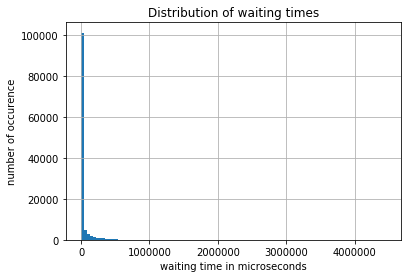

In [210]:
(optionData - optionData.shift())['created'].astype('timedelta64[us]').hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

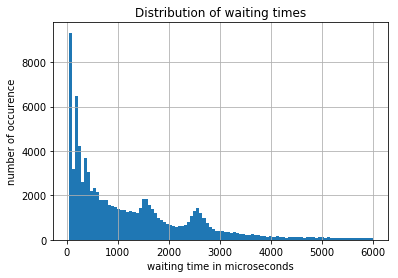

In [211]:
#closer look
dif = (optionData - optionData.shift()).astype('timedelta64[us]')
dif[dif['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

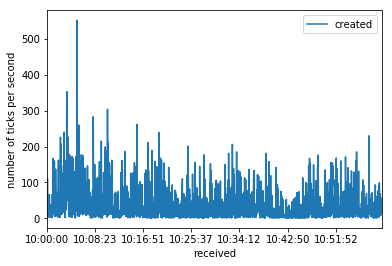

In [215]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()
#optionData2 = optionData2.mean(axis=1)

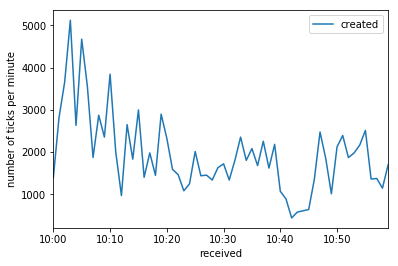

In [214]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per minute')
plt.show()